In [1]:
cols = ['id', 'name',
        # description text
       'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
        # host
       'host_id', 'host_name', 'host_since', #'host_location', #
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 
        # address
       'street', 'neighbourhood_cleansed', 'zipcode', #'neighbourhood', 'neighbourhood_group_cleansed',
       #'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country',
        # address location
       'latitude', 'longitude', 'is_location_exact',
        # property type and space
       'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', #Rmk: amenities is a dict(json?) 
        # and not many square_feet data
        # price
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 
        # availability
       'minimum_nights', 'maximum_nights', 'calendar_updated', #'has_availability'(null),
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',
        # reviews
       'number_of_reviews', 'first_review', 'last_review', 
       'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 
        # extra
       'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month']
date_cols = ['first_review', 'last_review','calendar_updated']

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
lstg_filename = '../data/boston/listings.csv'
df = pd.read_csv(lstg_filename, usecols=cols, parse_dates=date_cols)
# data clean
df['price'] = df['price'].str.replace("[$, ]", "").astype("float")

## Topic modeling
- **What are the topics of the neighborhood descriptions? --> See LDA to all data**
- **What is the proportion of topics for each neighborhood?**

In [1]:
# Import spaCy and load the language library
import spacy
nlp = spacy.load('en_core_web_sm')
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer, before="parser")
doc = nlp("This is a sentence. This is another sentence.")
assert len(list(doc.sents)) == 2

In [4]:
def is_excluded(token, avoidwords=[]):
    '''
    decide to include 'token' or not
    INPUT - token - token object in a doc
            avoidwords - additional words to exclude
    OUTPUT - is_excluded - boolean - whether to exlude the token from the list of lemmas
    '''
    rules = [token.is_stop,
             token.is_punct,
             token.is_space,
             token.like_num,
             token.lemma_ in avoidwords
            ]
    return any(rules)

In [5]:
def prepare_sentences(text, avoidwords=[]):
    if pd.notnull(text): # or isinstance(text, str):
        doc = nlp(text)
        sentences = []
        lsentences = []
        for sent in doc.sents:
            lemmas = []
            for token in sent:        
                if not is_excluded(token, avoidwords):
                    lemmas.append(token.lemma_)
                newtext = ' '.join(lemmas)
            if len(newtext):
                lsentences.append(newtext)
                sentences.append(sent.text)
        return lsentences, sentences
    else:
        print("empty text")
        return [], []

# test
prepare_sentences(u"""Tesla is looking at buying a U.S. startup in Boston for $6 million.
                  Startups are becoming juicy minutes after it.""",
                 avoidwords=['boston'])

(['Tesla look buy U.S. startup Boston $', 'startup juicy minute'],
 ['Tesla is looking at buying a U.S. startup in Boston for $6 million.',
  '\n                  Startups are becoming juicy minutes after it.'])

In [6]:
def prepare_data(dt, avoidwords=[]):
    texts = []
    ltexts = []
    #ntexts = []
    neighborhood_sentids = defaultdict(list)
    sofar = 0
    for index, overview, neighbourhood in zip(dt.index, dt.neighborhood_overview, dt.neighbourhood_cleansed):
        lsent, sent = prepare_sentences(overview, avoidwords)
        ltexts += lsent
        texts += sent
        #ntexts += [index]*len(sent)
        neighborhood_sentids[neighbourhood] += [i for i in range(sofar,sofar+len(sent))]
        sofar += len(sent)
    return ltexts, texts, neighborhood_sentids

# test
prepare_data(df.loc[:1, ["neighborhood_overview", "neighbourhood_cleansed"]])

(['roslindale quiet convenient friendly',
  'southern food try Redd Rozzie',
  'Italian Delfino Sophia Grotto great',
  'Birch St Bistro nice atmostphere little pricier',
  'cook Fish market fresh fish daily Tony make sausage italian food wide variety delicious cheese chocolate Cheese Cellar Birch St.',
  'room Roslindale diverse primarily residential neighborhood Boston',
  'connect public transportation neighborhood easy access car',
  'Roslindale Square nice business district supermarket',
  'bank bakery etc',
  'Guidebook recommendation',
  'Arnold Arboretum step away'],
 ['Roslindale is quiet, convenient and friendly.',
  " For Southern food try Redd's in Rozzie.",
  " Italian Delfino's or Sophia's Grotto are great.",
  'Birch St Bistro has nice atmostphere--a little pricier.',
  "  If you are cooking the Fish Market has fresh fish daily; Tony's makes his own sausages and has Italian foods;  for  a wide variety of delicious cheeses and chocolates go to the Cheese Cellar on Birch S

In [32]:
print(', '.join([n for n in df["neighbourhood_cleansed"].value_counts().index]))

Jamaica Plain, South End, Back Bay, Fenway, Dorchester, Allston, Beacon Hill, Brighton, South Boston, Downtown, East Boston, Roxbury, North End, Mission Hill, Charlestown, South Boston Waterfront, Chinatown, Roslindale, West End, West Roxbury, Hyde Park, Bay Village, Mattapan, Longwood Medical Area, Leather District


In [7]:
df["neighbourhood_cleansed"].value_counts().index

Index(['Jamaica Plain', 'South End', 'Back Bay', 'Fenway', 'Dorchester',
       'Allston', 'Beacon Hill', 'Brighton', 'South Boston', 'Downtown',
       'East Boston', 'Roxbury', 'North End', 'Mission Hill', 'Charlestown',
       'South Boston Waterfront', 'Chinatown', 'Roslindale', 'West End',
       'West Roxbury', 'Hyde Park', 'Bay Village', 'Mattapan',
       'Longwood Medical Area', 'Leather District'],
      dtype='object')

In [7]:
neighborhoods = df["neighbourhood_cleansed"].unique()
X = df[["neighborhood_overview", "neighbourhood_cleansed"]].dropna()#.drop_duplicates()
lsentences, sentences, neighborhood_sentids = prepare_data(X, 
                             avoidwords=['Boston','neighborhood','jp', 'JP',
                                         #'mi','mile','minute','min'
                                        ]
                             +' '.join(neighborhoods).split())

In [165]:
for st, lst in zip(sentences, lsentences):
    if 'jp' in lst:
        print(st, "----", lst)

JP has a rich arts and cultural scene that includes such major annual festivals as Wake Up the Earth, the Jamaica Plain Music Festival and the Jamaica Pond Lantern ParadeOne of JPs major sub-neighborhood is home to Boston's Latin Quarter bordering Roxbury: Egleston Square Boasting a wide array of businesses, JP is especially known across the city for its variety of prominent restaurants. ---- rich art cultural scene include major annual festival wake earth Music Festival Pond Lantern ParadeOne jps major sub home Latin Quarter border Egleston Square Boasting wide array business especially know city variety prominent restaurant


In [180]:
neighborhood_sentids.keys()

dict_keys(['Roslindale', 'Jamaica Plain', 'Mission Hill', 'Longwood Medical Area', 'Bay Village', 'Leather District', 'Chinatown', 'North End', 'Roxbury', 'South End', 'Back Bay', 'East Boston', 'Charlestown', 'West End', 'Beacon Hill', 'Downtown', 'Fenway', 'Brighton', 'West Roxbury', 'Hyde Park', 'Mattapan', 'Dorchester', 'South Boston Waterfront', 'South Boston', 'Allston'])

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(lsentences) # sentences or df["neighbourhood_cleansed"].dropna()

In [19]:
from sklearn.decomposition import LatentDirichletAllocation
nbtopics = 5
# rdstate = np.random.randint(100000)
LDA = LatentDirichletAllocation(n_components=nbtopics, random_state=42, #42 #7420 #rdstate
                               max_iter=80, evaluate_every=2, verbose=1)
# This can take awhile, we're dealing with a large amount of documents!
LDA.fit(dtm)

iteration: 1 of max_iter: 80
iteration: 2 of max_iter: 80, perplexity: 864.4874
iteration: 3 of max_iter: 80
iteration: 4 of max_iter: 80, perplexity: 789.4468
iteration: 5 of max_iter: 80
iteration: 6 of max_iter: 80, perplexity: 756.8131
iteration: 7 of max_iter: 80
iteration: 8 of max_iter: 80, perplexity: 742.2938
iteration: 9 of max_iter: 80
iteration: 10 of max_iter: 80, perplexity: 733.1653
iteration: 11 of max_iter: 80
iteration: 12 of max_iter: 80, perplexity: 727.0883
iteration: 13 of max_iter: 80
iteration: 14 of max_iter: 80, perplexity: 722.4206
iteration: 15 of max_iter: 80
iteration: 16 of max_iter: 80, perplexity: 719.2713
iteration: 17 of max_iter: 80
iteration: 18 of max_iter: 80, perplexity: 716.9630
iteration: 19 of max_iter: 80
iteration: 20 of max_iter: 80, perplexity: 714.8436
iteration: 21 of max_iter: 80
iteration: 22 of max_iter: 80, perplexity: 713.1237
iteration: 23 of max_iter: 80
iteration: 24 of max_iter: 80, perplexity: 712.3313
iteration: 25 of max_iter

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=2, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=80,
             mean_change_tol=0.001, n_components=5, n_jobs=None,
             n_topics=None, perp_tol=0.1, random_state=42,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [38]:
LDA.n_iter_, LDA.perplexity(dtm)

(43, 709.9403504506598)

In [110]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index+1}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]][::-1])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #1
['walk', 'minute', 'downtown', 'close', 'access', 'station', 'easy', 'line', 'city', 'location', 'right', 'away', 'min', 'area', 'stop', 'locate', 'short', 'distance', 'bus', 'public']


THE TOP 20 WORDS FOR TOPIC #2
['restaurant', 'shop', 'walk', 'store', 'bar', 'great', 'street', 'cafe', 'food', 'away', 'block', 'good', 'minute', 'grocery', 'distance', 'coffee', 'italian', 'corner', 'local', 'market']


THE TOP 20 WORDS FOR TOPIC #3
['quiet', 'city', 'diverse', 'area', 'safe', 'family', 'live', 'residential', 'young', 'community', 'great', 'friendly', 'professional', 'people', 'home', 'love', 'student', 'street', 'locate', 'old']


THE TOP 20 WORDS FOR TOPIC #4
['mi', 'mile', 'center', 'museum', 'new', 'hall', 'restaurant', 'university', 'house', 'boston', 'fine', 'england', 'faneuil', 'trail', 'major', 'arts', 'freedom', 'home', 'garden', 'prudential']


THE TOP 20 WORDS FOR TOPIC #5
['street', 'walk', 'park', 'historic', 'beautiful', 'charles', 'river'

In [111]:
topic_results = LDA.transform(dtm)

In [112]:
topic_asgn = topic_results.argmax(axis=1)

In [46]:
list(f"topic {i+1}" for i in range(nbtopics))

['topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5']

In [113]:
# average of percentages
d = {**{"neighborhood": list(neighborhood_sentids.keys())}, **{f"topic {i+1}":[] for i in range(nbtopics)}}
d["count"] = []
d["dominant_topic"] = []
for nghbd, sentids in neighborhood_sentids.items():
    c = np.average(topic_results[sentids], axis=0)
    for i in range(nbtopics):
        d[f"topic {i+1}"].append(c[i])
    d["count"].append(len(sentids))
    d["dominant_topic"].append(np.argmax(c))
H2 = pd.DataFrame(d).sort_values(by="count", ascending=False).round(3)
H2.set_index("neighborhood", inplace=True)
H2.to_csv("H2.csv")
H2 = H2.style.background_gradient(axis=0, subset=list(f"topic {i+1}" for i in range(nbtopics)))
H2

,topic 1,topic 2,topic 3,topic 4,topic 5,count,dominant_topic
neighborhood,,,,,,,
Jamaica Plain,0.184,0.258,0.257,0.07,0.232,1018,1
South End,0.18,0.278,0.198,0.105,0.24,691,1
Dorchester,0.206,0.213,0.313,0.116,0.152,577,2
Back Bay,0.209,0.162,0.139,0.098,0.391,509,4
Allston,0.27,0.285,0.236,0.061,0.147,484,1
Fenway,0.279,0.175,0.147,0.216,0.183,436,0
South Boston,0.319,0.234,0.182,0.134,0.131,435,0
Beacon Hill,0.193,0.256,0.142,0.092,0.317,433,4
East Boston,0.253,0.28,0.277,0.067,0.123,347,1


In [104]:
# average of percentages
d = {**{"neighborhood": list(neighborhood_sentids.keys())}, **{f"topic {i+1}":[] for i in range(nbtopics)}}
d["count"] = []
d["dominant_topic"] = []
for nghbd, sentids in neighborhood_sentids.items():
    c = np.average(topic_results[sentids], axis=0)
    for i in range(nbtopics):
        d[f"topic {i+1}"].append(c[i])
    d["count"].append(len(sentids))
    d["dominant_topic"].append(np.argmax(c))
H2 = pd.DataFrame(d).sort_values(by="count", ascending=False).round(3)
H2.set_index("neighborhood", inplace=True)

#H2bis = H2.copy()
#exclude_topic = 1
#H2bis.drop(columns=['topic 1'], inplace=True)
#subset = list(f"topic {i+1}" for i in range(nbtopics) if f"topic {i+1}" in H2bis.columns)
#H2bis[subset] = H2bis[subset].apply(lambda r: r/H2bis[subset].sum(axis=1))
H2_ = H2.sort_values(by="topic 5")
H2_.style.background_gradient(axis=0, subset=list(f"topic {i+1}" for i in range(nbtopics)))
#H2bis.style.background_gradient(axis=0, subset=subset)

,topic 1,topic 2,topic 3,topic 4,topic 5,count,dominant_topic
neighborhood,,,,,,,
Chinatown,0.421,0.092,0.068,0.337,0.082,84,0
Mission Hill,0.202,0.235,0.277,0.169,0.117,168,2
Roxbury,0.225,0.215,0.366,0.077,0.117,308,2
Brighton,0.317,0.291,0.202,0.069,0.121,331,0
East Boston,0.253,0.28,0.277,0.067,0.123,347,1
South Boston,0.319,0.234,0.182,0.134,0.131,435,0
West Roxbury,0.258,0.234,0.27,0.099,0.139,76,2
Allston,0.27,0.285,0.236,0.061,0.147,484,1
Longwood Medical Area,0.232,0.164,0.386,0.07,0.148,18,2


In [50]:
with open("h2.html", 'w') as f:
    f.write(H2.render())

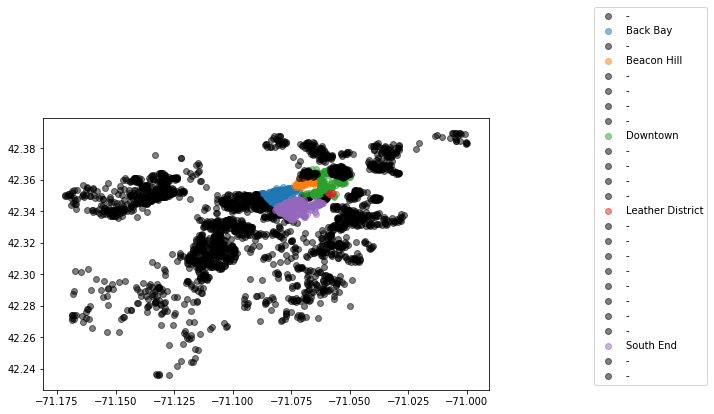

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for nghbd, grp in df[['neighbourhood_cleansed','longitude','latitude']].groupby('neighbourhood_cleansed'):
    if nghbd in ["Leather District", "Back Bay","South End","Downtown","Beacon Hill"]:
        x = grp['longitude']
        y = grp['latitude']
        plt.scatter(x, y, alpha=.5, label=f"{nghbd}")
    else:
        x = grp['longitude']
        y = grp['latitude']
        plt.scatter(x, y, alpha=.5, label=f"-", color="black")
plt.legend(loc=4, bbox_to_anchor=(1, 0., 0.5, 0.5))
plt.show()

In [109]:
import plotly.express as px
col = "topic 5"
df[col] = df["neighbourhood_cleansed"].apply(lambda n: H2_.loc[n,col])
#px.set_mapbox_access_token("pk.eyJ1IjoiYWxpZWxhZGkiLCJhIjoiY2s3anI3NnJoMHNmZzNmcHI0bzJ3M3o1ZyJ9.6Z_QDVttK5AYCbWtXzNGcw")
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color=col, 
                        hover_name="neighbourhood_cleansed", zoom=11,
                        center={'lat':42.32,'lon':-71.08}, width=700, height=700,
                        )

fig.update_layout(mapbox_style="basic") #stamen-terrain or open-street-map
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

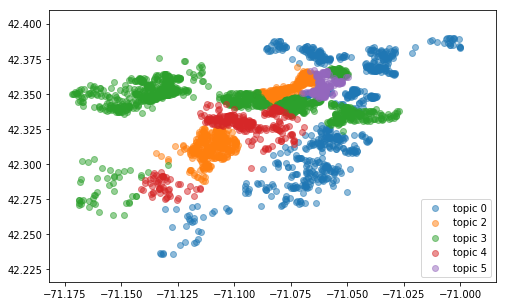

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for topic, grp in H2[['dominant_topic']].groupby('dominant_topic'):
    locs = df['neighbourhood_cleansed'].isin(grp.index)
    x = df.loc[locs,'longitude']
    y = df.loc[locs,'latitude']
    plt.scatter(x, y, alpha=.5, label=f"topic {topic}")
plt.legend()
plt.show()

In [115]:
df.columns

Index(['id', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'host_id', 'host_name', 'host_since', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'calendar_last_s

In [118]:
df["property_type"].value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

In [149]:
df["room_type"].value_counts()

Entire home/apt    2127
Private room       1378
Shared room          80
Name: room_type, dtype: int64

In [147]:
df_= df.dropna(subset=["property_type"]).copy()
df_["property_type_"] = "Other"
df_.loc[df_["property_type"].isin(["House","Townhouse","Villa"]), "property_type_"] = "House"
df_.loc[df_["property_type"].isin(["Apartment","Condominium"]), "property_type_"] = "Apartment"

In [ ]:
df_.groupby()

In [148]:
import plotly.express as px
ccol = "property_type_" # "property_type", "room_type"
#df_= df[~df[ccol].isin(["House"])].dropna(subset=[ccol])
#px.set_mapbox_access_token("pk.eyJ1IjoiYWxpZ
#WxhZGkiLCJhIjoiY2s3anI3NnJoMHNmZzNmcHI0bzJ3M3o1ZyJ9.6Z_QDVttK5AYCbWtXzNGcw")
fig = px.scatter_mapbox(df_, lat="latitude", lon="longitude", color=ccol, 
                        hover_name="neighbourhood_cleansed", zoom=11, opacity=0.7,
                        center={'lat':42.32,'lon':-71.08}, width=700, height=700,
                        )

fig.update_layout(mapbox_style="basic") #stamen-terrain or open-street-map
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [134]:
import plotly.express as px
ccol = "room_type" # "property_type", "room_type"
df_= df.dropna(subset=[ccol])
#df_= df[~df[ccol].isin(["House"])].dropna(subset=[ccol])
#px.set_mapbox_access_token("pk.eyJ1IjoiYWxpZ
#WxhZGkiLCJhIjoiY2s3anI3NnJoMHNmZzNmcHI0bzJ3M3o1ZyJ9.6Z_QDVttK5AYCbWtXzNGcw")
fig = px.scatter_mapbox(df_, lat="latitude", lon="longitude", color=ccol, 
                        hover_name="neighbourhood_cleansed", zoom=11, opacity=0.7,
                        center={'lat':42.32,'lon':-71.08}, width=700, height=700,
                        )

fig.update_layout(mapbox_style="basic") #stamen-terrain or open-street-map
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Other attempts

In [13]:
from sklearn.decomposition import LatentDirichletAllocation
nbtopics = 4
perplexity = 5000
LDA = None
for rdstate in np.random.randint(10000, size=3):
    LDA_ = LatentDirichletAllocation(n_components=nbtopics, random_state=rdstate, #42 #7420 #rdstate
                                   max_iter=40, evaluate_every=2, verbose=1)
    # This can take awhile, we're dealing with a large amount of documents!
    LDA_.fit(dtm)
    perplexity_ = LDA_.perplexity(dtm)
    if perplexity_ < perplexity:
        LDA = LDA_
        perplexity = perplexity_

iteration: 1 of max_iter: 40


KeyboardInterrupt: 

In [195]:
from sklearn.decomposition import LatentDirichletAllocation
nbtopics = 6
rdstates = np.random.randint(10000, size=10)
for rdstate in rdstates:
    print("randomstate:",rdstate,"-------------")
    LDA = LatentDirichletAllocation(n_components=nbtopics,random_state=rdstate)#42
    # This can take awhile, we're dealing with a large amount of documents!
    LDA.fit(dtm)
    for index, topic in enumerate(LDA.components_):
        print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
        print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]][::-1])
        print('\n')
    print("-"*20)
    print("-"*20)

randomstate: 2383 -------------
THE TOP 15 WORDS FOR TOPIC #0
['mile', 'city', 'public', 'restaurant', 'locate', 'street', 'garden', 'downtown', 'park', 'home', 'access', 'transportation', 'easy', 'area', 'close']


THE TOP 15 WORDS FOR TOPIC #1
['mi', 'center', 'museum', 'restaurant', 'university', 'hall', 'shopping', 'fine', 'trail', 'charles', 'hospital', 'freedom', 'college', 'prudential', 'walk']


THE TOP 15 WORDS FOR TOPIC #2
['restaurant', 'shop', 'bar', 'store', 'great', 'cafe', 'street', 'walk', 'block', 'coffee', 'food', 'grocery', 'away', 'good', 'new']


THE TOP 15 WORDS FOR TOPIC #3
['diverse', 'love', 'city', 'great', 'park', 'enjoy', 'people', 'community', 'local', 'resident', 'street', 'location', 'space', 'lot', 'vibrant']


THE TOP 15 WORDS FOR TOPIC #4
['quiet', 'safe', 'area', 'historic', 'street', 'family', 'friendly', 'beautiful', 'live', 'good', 'professional', 'house', 'young', 'location', 'know']


THE TOP 15 WORDS FOR TOPIC #5
['walk', 'minute', 'away', 'stre

['street', 'mile', 'restaurant', 'charles', 'garden', 'common', 'home', 'block', 'newbury', 'river', 'public', 'locate', 'good', 'away', 'avenue']


THE TOP 15 WORDS FOR TOPIC #5
['restaurant', 'shop', 'walk', 'bar', 'great', 'store', 'square', 'cafe', 'away', 'shopping', 'grocery', 'minute', 'step', 'distance', 'food']


--------------------
--------------------
randomstate: 4843 -------------
THE TOP 15 WORDS FOR TOPIC #0
['street', 'restaurant', 'shop', 'park', 'heart', 'right', 'cafe', 'location', 'line', 'tree', 'block', 'know', 'walk', 'attraction', 'locate']


THE TOP 15 WORDS FOR TOPIC #1
['city', 'place', 'food', 'italian', 'people', 'old', 'historic', 'house', 'great', 'like', 'stay', 'park', 'good', 'step', 'square']


THE TOP 15 WORDS FOR TOPIC #2
['mile', 'restaurant', 'home', 'garden', 'hall', 'brewery', 'downtown', 'good', 'faneuil', 'southie', 'trail', 'freedom', 'td', 'adams', 'locate']


THE TOP 15 WORDS FOR TOPIC #3
['restaurant', 'mi', 'bar', 'shop', 'store', 'walk'

## More

In [43]:
from collections import Counter
Counter(topic_asgn)

Counter({4: 1521, 1: 1089, 2: 989, 0: 1789, 3: 1853})

In [44]:
# percentage of dominant topics
d = {"neighborhood": list(neighborhood_sentids.keys())}
for i in range(nbtopics):
    d[i] = []
d["count"] = []
for nghbd, sentids in neighborhood_sentids.items():
    c = Counter([topic_asgn[i] for i in sentids])
    count = 0
    for i in range(nbtopics):
        di = c.get(i) if c.get(i) else 0
        d[i].append(di)
        count += di
    d["count"].append(count)
H = pd.DataFrame(d).sort_values(by="count", ascending=False)
for i in range(nbtopics):
    H[i] = H[i]/H["count"]*100
H    

,neighborhood,0,1,2,3,4,count
1,Jamaica Plain,18.431373,20.686275,6.078431,28.235294,26.568627,1020
9,South End,24.167873,10.853835,18.379161,26.917511,19.681621,691
21,Dorchester,29.809359,10.918544,6.239168,22.876950,30.155979,577
10,Back Bay,28.880157,14.734774,22.396857,22.789784,11.198428,509
24,Allston,24.173554,9.710744,12.396694,31.404959,22.314050,484
23,South Boston,35.682819,15.198238,2.863436,33.920705,12.334802,454
16,Fenway,19.266055,19.495413,25.229358,29.128440,6.880734,436
14,Beacon Hill,23.271889,13.594470,21.658986,23.041475,18.433180,434
11,East Boston,31.412104,15.850144,8.357349,18.731988,25.648415,347
17,Brighton,23.867069,8.761329,7.854985,38.670695,20.845921,331


In [45]:
H.style.background_gradient(axis=1, subset=list(range(nbtopics)))

,neighborhood,0,1,2,3,4,count
1,Jamaica Plain,18.4314,20.6863,6.07843,28.2353,26.5686,1020
9,South End,24.1679,10.8538,18.3792,26.9175,19.6816,691
21,Dorchester,29.8094,10.9185,6.23917,22.8769,30.156,577
10,Back Bay,28.8802,14.7348,22.3969,22.7898,11.1984,509
24,Allston,24.1736,9.71074,12.3967,31.405,22.314,484
23,South Boston,35.6828,15.1982,2.86344,33.9207,12.3348,454
16,Fenway,19.2661,19.4954,25.2294,29.1284,6.88073,436
14,Beacon Hill,23.2719,13.5945,21.659,23.0415,18.4332,434
11,East Boston,31.4121,15.8501,8.35735,18.732,25.6484,347
17,Brighton,23.8671,8.76133,7.85498,38.6707,20.8459,331


In [46]:
for nghbd, sentids in neighborhood_sentids.items():
    print(nghbd, Counter([topic_asgn[i] for i in sentids]))
    print("------")

Roslindale Counter({0: 48, 4: 46, 3: 38, 1: 35, 2: 19})
------
Jamaica Plain Counter({3: 288, 4: 271, 1: 211, 0: 188, 2: 62})
------
Mission Hill Counter({4: 45, 3: 43, 2: 32, 0: 30, 1: 18})
------
Longwood Medical Area Counter({1: 5, 0: 4, 4: 4, 3: 4, 2: 1})
------
Bay Village Counter({0: 19, 4: 10, 2: 10, 3: 7, 1: 4})
------
Leather District Counter({0: 22, 3: 3, 4: 1})
------
Chinatown Counter({2: 32, 3: 22, 0: 22, 1: 8})
------
North End Counter({1: 87, 4: 71, 3: 58, 0: 54, 2: 40})
------
Roxbury Counter({4: 121, 0: 58, 3: 56, 2: 43, 1: 30})
------
South End Counter({3: 186, 0: 167, 4: 136, 2: 127, 1: 75})
------
Back Bay Counter({0: 147, 3: 116, 2: 114, 1: 75, 4: 57})
------
East Boston Counter({0: 109, 4: 89, 3: 65, 1: 55, 2: 29})
------
Charlestown Counter({0: 53, 4: 45, 3: 28, 1: 24, 2: 19})
------
West End Counter({2: 18, 3: 15, 1: 14, 4: 8, 0: 2})
------
Beacon Hill Counter({0: 101, 3: 100, 2: 94, 4: 80, 1: 59})
------
Downtown Counter({0: 76, 2: 70, 3: 60, 1: 50, 4: 40})
---

In [37]:
for i in np.random.randint(len(sentences), size=10):
    print(f"{sentences[i]} : {topic_asgn[i]} - {topic_results[i]*100}")
    print(f"{[cv.get_feature_names()[i] for i in LDA.components_[topic_asgn[i]].argsort()[-10:]][::-1]}")
    print("-----------")

Easy access to dozens of restaurants, shops, bars, etc. : 1 - [31.7712162  59.63587014  2.85715196  2.86992704  2.86583467]
['restaurant', 'shop', 'walk', 'store', 'bar', 'great', 'street', 'cafe', 'food', 'away']
-----------
You will find that the locals are welcoming and full of life and character, making your stay truly unique and memorable! : 2 - [ 2.29127141  2.25055679 46.67388548  2.29399229 46.49029403]
['quiet', 'city', 'diverse', 'area', 'safe', 'family', 'live', 'residential', 'young', 'community']
-----------
8 minute walk up to Centre Street where there are diverse and restaurants and cafes, various small stores, Post Office etc. : 1 - [ 1.6918926  83.62455554 11.32551774  1.66878217  1.68925195]
['restaurant', 'shop', 'walk', 'store', 'bar', 'great', 'street', 'cafe', 'food', 'away']
-----------
Brighton/Allston is a great neighborhood 15 minutes outside of downtown Boston. : 0 - [83.79770235  4.11809452  4.06234783  4.00488953  4.01696577]
['walk', 'minute', 'downtown', 

In [47]:
# average of percentages
d = {**{"neighborhood": list(neighborhood_sentids.keys())}, **{i:[] for i in range(nbtopics)}}
d["count"] = []
d["dominant_topic"] = []
for nghbd, sentids in neighborhood_sentids.items():
    c = np.average(topic_results[sentids], axis=0)
    for i in range(nbtopics):
        d[i].append(c[i])
    d["count"].append(len(sentids))
    d["dominant_topic"].append(np.argmax(c))
H2 = pd.DataFrame(d).sort_values(by="count", ascending=False)
H2.set_index("neighborhood", inplace=True)
H2

,0,1,2,3,4,count,dominant_topic
neighborhood,,,,,,,
Jamaica Plain,0.192641,0.208769,0.102107,0.251195,0.245288,1020,3
South End,0.232943,0.128318,0.191227,0.252426,0.195086,691,3
Dorchester,0.275323,0.136071,0.098577,0.231545,0.258484,577,0
Back Bay,0.273544,0.161840,0.214989,0.214488,0.135138,509,0
Allston,0.232758,0.117718,0.150030,0.293765,0.205729,484,3
South Boston,0.303149,0.168845,0.069990,0.308285,0.149731,454,3
Fenway,0.194729,0.193180,0.232903,0.281842,0.097347,436,3
Beacon Hill,0.219882,0.154285,0.207965,0.236706,0.181162,434,3
East Boston,0.295370,0.163079,0.116643,0.183512,0.241395,347,0


In [31]:
H2.style.background_gradient(axis=1, subset=list(range(nbtopics)))

,0,1,2,3,4,5,count,dominant_topic
neighborhood,,,,,,,,
Jamaica Plain,0.165719,0.113612,0.216944,0.210077,0.203607,0.0900412,1020,2
South End,0.17941,0.116634,0.150486,0.222853,0.146039,0.184578,691,3
Dorchester,0.244084,0.0813963,0.0999167,0.190787,0.241634,0.142182,577,0
Back Bay,0.197417,0.12032,0.224254,0.173069,0.101275,0.183665,509,2
Allston,0.23932,0.0960434,0.130422,0.269339,0.175323,0.089553,484,3
South Boston,0.290612,0.116212,0.0667883,0.296933,0.146514,0.0829406,454,3
Fenway,0.173871,0.14312,0.159458,0.26202,0.0836058,0.177926,436,3
Beacon Hill,0.164741,0.101236,0.253977,0.191696,0.101395,0.186955,434,2
East Boston,0.263649,0.157479,0.125835,0.181798,0.185135,0.086104,347,0


In [48]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]][::-1])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['walk', 'minute', 'away', 'line', 'downtown', '10', 'min', 'street', 'station', 'locate', 'center', 'public', 'historic', 'stop', 'park']


THE TOP 15 WORDS FOR TOPIC #1
['mile', 'city', 'pond', 'location', 'arboretum', 'home', 'enjoy', 'park', 'good', 'great', 'beautiful', 'river', 'arnold', 'charles', 'garden']


THE TOP 15 WORDS FOR TOPIC #2
['mi', 'street', 'center', 'university', 'restaurant', 'newbury', 'new', 'museum', 'house', 'college', 'fine', 'hall', 'copley', 'charles', 'prudential']


THE TOP 15 WORDS FOR TOPIC #3
['restaurant', 'shop', 'walk', 'bar', 'store', 'great', 'close', 'cafe', 'distance', 'shopping', 'grocery', 'offer', 'square', 'coffee', 'away']


THE TOP 15 WORDS FOR TOPIC #4
['quiet', 'diverse', 'family', 'safe', 'area', 'city', 'live', 'residential', 'young', 'friendly', 'professional', 'community', 'love', 'know', 'street']




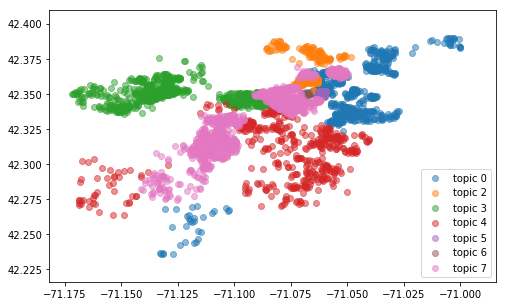

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for topic, grp in H2[['neighborhood','dominant_topic']].groupby('dominant_topic'):
    locs = df['neighbourhood_cleansed'].isin(grp['neighborhood'].values)
    x = df.loc[locs,'longitude']
    y = df.loc[locs,'latitude']
    plt.scatter(x, y, alpha=.5, label=f"topic {topic}")
plt.legend()
plt.show()

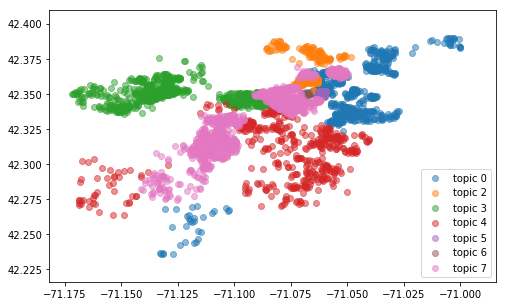

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for topic, grp in H2[['neighborhood','dominant_topic']].groupby('dominant_topic'):
    locs = df['neighbourhood_cleansed'].isin(grp['neighborhood'].values)
    x = df.loc[locs,'longitude']
    y = df.loc[locs,'latitude']
    plt.scatter(x, y, alpha=.5, label=f"topic {topic}")
plt.legend()
plt.show()

In [145]:
import pandas as pd
import plotly.express as px
df["dominant_topic"] = df["neighbourhood_cleansed"].apply(lambda n: H2.loc[n,"dominant_topic"])
#px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="dominant_topic", 
                        hover_name="neighbourhood_cleansed", zoom=14
                        )

fig.update_layout(mapbox_style="open-street-map") #stamen-terrain or open-street-map
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

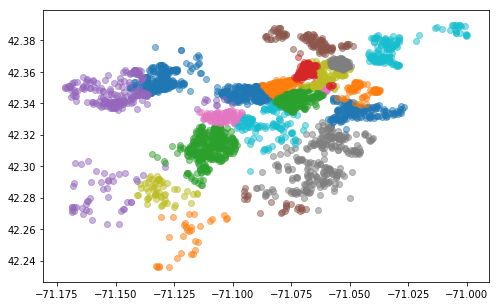

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for neighborhood, grp in H2[['neighborhood','dominant_topic']].groupby('neighborhood'):
    locs = df['neighbourhood_cleansed'].isin(grp['neighborhood'].values)
    x = df.loc[locs,'longitude']
    y = df.loc[locs,'latitude']
    plt.scatter(x, y, alpha=.5, label=f"{neighborhood}")
#plt.legend()
plt.show()

In [22]:
df.loc[[428, 481], "neighborhood_overview"].dropna().drop_duplicates()

428    Major Attractions: •Restaurants – Il Mondo Piz...
481    Major Attractions: •Restaurants – Sushi Statio...
Name: neighborhood_overview, dtype: object

In [20]:
# Test
sent = ' mi '
testsub = df["neighborhood_overview"].dropna().drop_duplicates()
i = 0
for r in testsub:
    if all(s in r for s in sent.split()):
        print(r, '--', testsub.index[i])
        print('----')
    i += 1

The LOCATION: Roslindale is a safe and diverse Boston neighborhood located between Jamaica Plain and West Roxbury. This apartment is on Ardale Street, a quiet side street off Centre Street.  This is about one-half mile from Faulkner Hospital, walking distance to the renowned Arnold Arboretum park (look for it on (SENSITIVE CONTENTS HIDDEN)), and about 20-minute drive to the Longwood Medical Center area. I have easy, restriction-free, on-street parking here, and a back yard. Just one block from the house, there is a 7-11 convenience store, a dry-cleaner, a Mexican restaurant, a pizza parlor, a popular sports bar and grill (similar to an Irish Pub), and another restaurant for breakfast and lunch.  The house is located 1/2 mile from Roslindale Square where you will find more restaurants, 4 bakeries, the public library and the post office. There is a superb farmers market here every Saturday. The fast-train to downtown Boston stops there, too. -- 2
----
I love the proximity to downtown, th

This wonderful 7 floor mid-rise building is located in the heart of the city and blends the charm of an old Boston neighborhood with all the modern conveniences. Located in Boston's Fenway cultural district, this property is opposite Landmark Center and Fenway Park is two blocks away, as well as dozens of great restaurants and retail shops.  -- 2375
----
Movie theaters, retail stores, excellent cuisine, bars, public transportation, Fenway Park, grocery and liquor stores are all only 5 minutes or less away. -- 2382
----
Great neighborhood, very safe.  You are 5 minutes walk to Fenway metro station, buses are even closer, 5 minutes walk to Fenway Park (home of the Redsox), cut through the main park and be at the Boston Museum of Fine Arts in 5 minutes.  There are lots of great restaurants, bars, and nightlife all within 5 minutes walk!  The 24 hour grocery store is only one block away and has just about anything you would need. -- 2387
----
The apartment is situated in the heart of Fenwa

### Other

In [353]:
_df = pd.read_csv(lstg_filename, nrows=3)
_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [356]:
_df.loc[0, 'neighborhood_overview']

"Roslindale is quiet, convenient and friendly.  For Southern food try Redd's in Rozzie.  Italian Delfino's or Sophia's Grotto are great. Birch St Bistro has nice atmostphere--a little pricier.   If you are cooking the Fish Market has fresh fish daily; Tony's makes his own sausages and has Italian foods;  for  a wide variety of delicious cheeses and chocolates go to the Cheese Cellar on Birch St."

In [351]:
reviews = pd.read_csv('../data/boston/reviews.csv', nrows=3)
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [357]:
reviews.loc[0]

listing_id                                                 1178162
id                                                         4724140
date                                                    2013-05-21
reviewer_id                                                4298113
reviewer_name                                              Olivier
comments         My stay at islam's place was really cool! Good...
Name: 0, dtype: object